# Transfer Learning for Cell Classification with Caffe 

### 1. Initialization

In [1]:
import caffe
from caffe import layers as L
from caffe import params as P
from caffe.proto import caffe_pb2
from pylab import *
import os
import tempfile
import fnmatch
from skimage import io
import numpy as np
%matplotlib inline

# uncomment this if you want to use the GPU
#caffe.set_device(0)
#caffe.set_mode_gpu()

In [2]:
# caffe instalation path (change to your local caffe home folder)
caffe_root = '/Users/maryana/bin/caffe/'
# image database path (change to the DB location in your machine)
img_root = '/Volumes/SUSHI_HD/SUSHI/CellCounter/toprocess/patchDB/cells/'

NUM_LABELS = 3
NUM_IMGNET_LABELS = 1000
CELL_LABELS = ['Red (CP13)', 'Green (casp-6)', 'Yellow (overlap)']

In [3]:
# initialize training params and weights
weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel' #load pretrained weights
weight_param = dict(lr_mult=1, decay_mult=1)
bias_param = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]
frozen_param = [dict(lr_mult=0)] * 2

#### Create Mean Image

In [4]:
def compute_mean_image_RGB(root_dir,binary_file,shape):          
    ncount = 0
    meanR = np.zeros(shape)
    meanG = np.zeros(shape)
    meanB = np.zeros(shape)

    for root, dir, files in os.walk(root_dir):
        for fname in fnmatch.filter(files, '*.jpg'): 
            img_path = os.path.join(root,fname)
            try:
                img = io.imread(img_path)
                img = img.astype(float)  
            except:
                print('Error reading {}'.format(fname))
                continue
            R = img[:,:,0]
            G = img[:,:,1]
            B = img[:,:,2]
            ncount+=1
            deltaR = R - meanR
            deltaG = G - meanG
            deltaB = B - meanB
            meanR += (deltaR/ncount)
            meanG += (deltaG/ncount)
            meanB += (deltaB/ncount)

    print('Total number of images processed: {}'.format(ncount))
    mR = meanR.reshape(1,meanR.shape[0],meanR.shape[1]) #caffe batch format
    mG = meanG.reshape(1,meanG.shape[0],meanG.shape[1]) #caffe format
    mB = meanB.reshape(1,meanB.shape[0],meanB.shape[1]) #caffe format
    mean_img = np.concatenate((mB,mG,mR),axis=0) #BGR is the standard in caffe
    #save image as caffe binaryproto
    blob = caffe.io.array_to_blobproto(np.asarray(mean_img.reshape([1,3,shape[0],shape[1]])))
    binaryproto_file = open(binary_file, 'wb+')
    binaryproto_file.write(blob.SerializeToString())
    binaryproto_file.close()

In [5]:
mean_img_path = img_root + 'mean_image.binaryproto'
compute_mean_image_RGB(img_root,mean_img_path,[256,256])

Error reading ._9777.12_146_drn-f_0000_class0.jpg
Total number of images processed: 844


###  2. Setup Network

In [6]:
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param, weight_filler=dict(type='gaussian', std=0.005), bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,weight_filler=weight_filler,bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000, retrain_layers=False, learn_all=False, tmp_file=True):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6

    # fine-tune the network, change layer name, unfreeze learning rate
    if retrain_layers:
        fc7 = L.InnerProduct(fc7input, num_output=4096, param=learned_param,
                             weight_filler=dict(type='gaussian', std=0.005),
                             bias_filler=dict(type='constant', value=0.1))
        n.__setattr__('fc7_new', fc7)
        relu7 = L.ReLU(fc7, in_place=True)
        n.__setattr__('relu7_new',relu7)
    else:
        n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
        relu7 = n.relu7

    if train:
        n.drop7 = fc8input = L.Dropout(relu7, in_place=True)
    else:
        fc8input = relu7

    # fine-tune the network, change layer name, unfreeze learning rate
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    if num_classes != NUM_IMGNET_LABELS:
        n.__setattr__('fc8_new', fc8)
    else:
        n.__setattr__('fc8', fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)

    # write the net to a temporary file and return its filename
    if tmp_file:
        with tempfile.NamedTemporaryFile(delete=False) as f:
            f.write(str(n.to_proto()))
            return f.name
    else:
        net_name = img_root + 'cell_net.prototxt'
        with open(net_name,'w') as f:
            f.write(str(n.to_proto()))
            return net_name

In [7]:
def dummy_caffenet(train=False, nshape=[1, 3, 227, 227]):
    dummy_data = L.DummyData(shape=dict(dim=nshape))
    net_filename = caffenet(data=dummy_data, train=train)
    return net_filename

In [8]:
def cell_net(train=True, learn_all=False, retrain_layers=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = img_root + '%s.txt' % subset # .txt with training/test file lists
    transform_param = dict(mirror=train, crop_size=227, mean_file=img_root + 'mean_image.binaryproto') #mean image
    style_data, style_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=NUM_LABELS,
                    retrain_layers=retrain_layers,
                    learn_all=learn_all)

### 3. Some Basic Stuff First 

In [9]:
# load the mean image and compute mean values
def load_mean_values(bp_file):
    blob = caffe_pb2.BlobProto()
    data = open(bp_file, 'rb').read()
    blob.ParseFromString(data)
    raw_data = caffe.io.blobproto_to_array(blob)
    arr = np.array(raw_data)
    out = arr[0]
    mu = out.mean(1).mean(1) #mean values, in BGR order
    return mu

# prepare image to be displayed
def deprocess_image(image,mu):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [mu[2],mu[1],mu[0]]
    image[image < 0], image[image > 255] = 0, 255
    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)
    return image

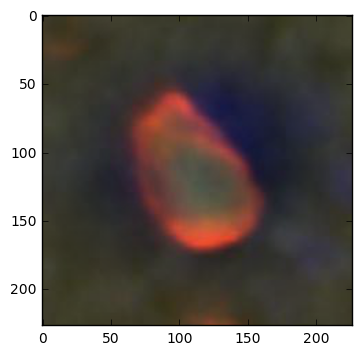

In [10]:
#################################
# Test: create a CellNet and display an image loaded by the network
#################################

# create an uninitialized network
img_index = 10
untrained_style_net = caffe.Net(cell_net(train=False, subset='train'),weights, caffe.TEST)
# run the network to load some test data.
untrained_style_net.forward()
# get a batch of data and its respective labels
style_data_batch = untrained_style_net.blobs['data'].data.copy()
style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)
# get an image sample (note that the image is transformed and can't be displayed right away)
image = style_data_batch[img_index]
# load our mean image file and compute the mean values
mu = load_mean_values(img_root + 'mean_image.binaryproto')
# process the image for displaying
dep_image = deprocess_image(image,mu)
plt.imshow(dep_image)

In [11]:
#################################
# Test: create a CaffeNet to classify a cell loaded from disk
#################################

# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
# create network
imagenet_net_name = dummy_caffenet() #imagenet has 1000 classes
imagenet_net = caffe.Net(imagenet_net_name,weights,caffe.TEST)
# input image
imagenet_net.blobs['data'].data[0,...] = image #note the image is already transformed
probs = imagenet_net.forward(start='conv1')['probs'][0]
top_k = (-probs).argsort()[:5] #top 5 predicted classes
print 'top 5 predicted ImageNet labels:'
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], imagenet_labels[p])
                for i, p in enumerate(top_k))

top 5 predicted ImageNet labels:
	(1) 52.37% n01443537 goldfish, Carassius auratus
	(2) 34.16% n09472597 volcano
	(3)  5.66% n01910747 jellyfish
	(4)  1.17% n12620546 hip, rose hip, rosehip
	(5)  0.92% n03590841 jack-o'-lantern


In [12]:
#################################
# Test: load image from disk, transform it and use original CaffeNet to classify it
#################################

# create transformer
transformer = caffe.io.Transformer({'data': imagenet_net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel (mu is BGR)
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [13]:
orig_image = caffe.io.load_image(img_root + '807.13_104_drn_f_0000_class2.jpg')
transf_image = transformer.preprocess('data',orig_image)
imagenet_net.blobs['data'].data[0,...] = transf_image
probs = imagenet_net.forward(start='conv1')['probs'][0]
top_k = (-probs).argsort()[:5] #top 5 predicted classes
print 'top 5 predicted ImageNet labels:'
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], imagenet_labels[p])
                for i, p in enumerate(top_k))

top 5 predicted ImageNet labels:
	(1) 85.14% n09472597 volcano
	(2) 10.08% n01443537 goldfish, Carassius auratus
	(3)  0.67% n02321529 sea cucumber, holothurian
	(4)  0.54% n01910747 jellyfish
	(5)  0.50% n03590841 jack-o'-lantern


### 4. Create solvers

In [14]:
def solver(train_net_path, test_net_path=None, base_lr=0.001, tmp_file = True):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    s.iter_size = 1
    s.max_iter = 100000     # # of times to update the net (training iterations)
    s.type = 'SGD'
    s.base_lr = base_lr
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000
    s.momentum = 0.9
    s.weight_decay = 5e-4
    s.display = 1000
    s.snapshot = 10000
    s.snapshot_prefix = img_root + 'fine_tune_2layers'

    #s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    if tmp_file:
        with tempfile.NamedTemporaryFile(delete=False) as f:
            f.write(str(s))
            return f.name
    else:
        solver_file = img_root + 'cell_net.solver'
        with open(solver_file,'w') as f:
            f.write(str(s))
            return solver_file
       
    
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

### 5. Train the Network

In [15]:
niter = 100  # number of iterations to train

# reset style_solver as before.
cell_solver_filename = solver(cell_net(train=True, retrain_layers=True))
cell_solver = caffe.get_solver(cell_solver_filename)
cell_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from the pretrained weights.
scratch_cell_solver_filename = solver(cell_net(train=True, retrain_layers=True))
scratch_cell_solver = caffe.get_solver(scratch_cell_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', cell_solver), ('scratch', scratch_cell_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

Running solvers for 100 iterations...
  0) pretrained: loss=1.099, acc=40%; scratch: loss=1.099, acc=40%
 10) pretrained: loss=0.722, acc=82%; scratch: loss=1.073, acc=40%
 20) pretrained: loss=0.528, acc=78%; scratch: loss=1.011, acc=50%
 30) pretrained: loss=0.784, acc=76%; scratch: loss=1.079, acc=46%
 40) pretrained: loss=0.601, acc=72%; scratch: loss=1.014, acc=52%
 50) pretrained: loss=0.811, acc=70%; scratch: loss=1.065, acc=42%
 60) pretrained: loss=0.586, acc=74%; scratch: loss=1.062, acc=44%
 70) pretrained: loss=0.537, acc=76%; scratch: loss=1.065, acc=46%
 80) pretrained: loss=0.598, acc=78%; scratch: loss=1.068, acc=38%
 90) pretrained: loss=0.792, acc=66%; scratch: loss=1.065, acc=40%
 99) pretrained: loss=0.583, acc=80%; scratch: loss=1.106, acc=42%
Done.


### 6. Test the Network

In [16]:
def eval_net(weights, test_iters=10):
    test_net = caffe.Net(cell_net(train=False, retrain_layers=True), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [17]:
train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
cell_weights, scratch_cell_weights = weights['pretrained'], weights['scratch']

test_net, accuracy = eval_net(cell_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_net(scratch_cell_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, trained from ImageNet initialization: 87.0%
Accuracy, trained from   random initialization: 35.8%


### 7. Let's Classify Some Images

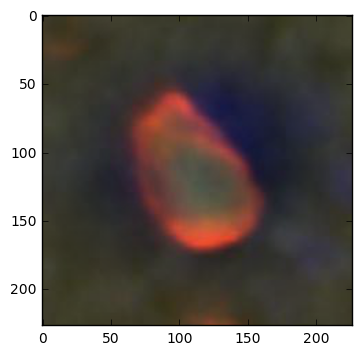

In [18]:
# instatiate another network and initilize it with our just trained weights
cell_net = caffe.Net(cell_net(train=False, subset='train', retrain_layers=True),cell_weights, caffe.TEST)

# input image to network
cell_net.blobs['data'].data[0,...] = image
plt.imshow(dep_image)

In [19]:
probs = cell_net.forward(start='conv1')['probs'][0]
top_k = (-probs).argsort()[:3] #top 3 predicted classes
print 'Label predictions:'
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], CELL_LABELS[p])
                for i, p in enumerate(top_k))

Label predictions:
	(1) 93.85% Yellow (overlap)
	(2)  6.06% Red (CP13)
	(3)  0.09% Green (casp-6)


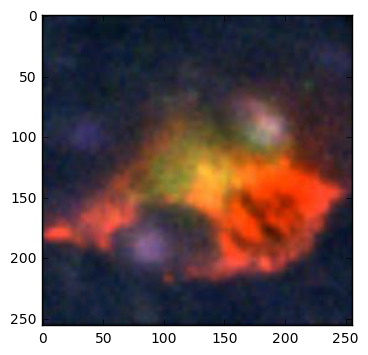

In [20]:
# input another image
cell_net.blobs['data'].data[0,...] = transf_image
plt.imshow(orig_image)

In [21]:
probs = cell_net.forward(start='conv1')['probs'][0]
top_k = (-probs).argsort()[:3] #top 3 predicted classes
print 'Label predictions:'
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], CELL_LABELS[p])
                for i, p in enumerate(top_k))

Label predictions:
	(1) 61.87% Yellow (overlap)
	(2) 37.90% Red (CP13)
	(3)  0.23% Green (casp-6)
